In [19]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid'])
import pymc3 as pm
import numpy as np
import pandas as pd

%matplotlib inline

### Weighted posterior predictive samples

In [20]:
d = pd.read_csv('../../Statistical-Rethinking-with-Python-and-PyMC3/Data/milk.csv', 
                header=0, delimiter=';')
df = d[['kcal.per.g', 'mass', 'neocortex.perc']].dropna()

df['log_mass'] = np.log(df['mass'])
df['log_mass'] -= df['log_mass'].mean()

df['neocortex'] = df['neocortex.perc'] / 100
df['neocortex'] -= df['neocortex'].mean()

df.drop(columns=['mass', 'neocortex.perc'], inplace=True)
df.head()

,kcal.per.g,log_mass,neocortex
0,0.49,-0.831486,-0.124159
5,0.47,0.158913,-0.030359
6,0.56,0.181513,-0.030359
7,0.89,-0.579032,0.000641
9,0.92,-1.884978,0.012741


### First model using only neocortex

In [21]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', 10)
    
    mu = alpha + beta * df['neocortex']
    
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, 
                     observed=df['kcal.per.g'])
    
    trace_0 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:06<00:00, 817.26draws/s] 


### Second model using only log mass

In [22]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', 10)
    
    mu = alpha + beta * df['log_mass']
    
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, 
                     observed=df['kcal.per.g'])
    
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 910.02draws/s] 


### Third model using both neocortex and log mass

In [23]:
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    sigma = pm.HalfNormal('sigma', 10)
    
    mu = alpha + pm.math.dot(beta, 
                             df[['log_mass', 'log_mass']].T)
    
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, 
                     observed=df['kcal.per.g'])
    
    trace_2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:52<00:00, 49.65draws/s] 
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


### Plot three traces

GridSpec(1, 2, width_ratios=[3, 1])

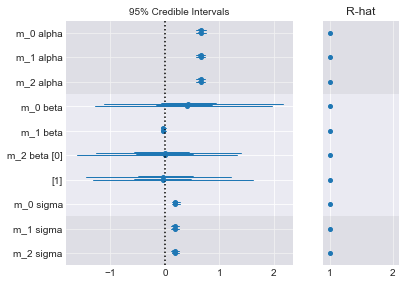

In [24]:
traces = [trace_0, trace_1, trace_2]
pm.forestplot(traces)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ab9ca20>,
      dtype=object)

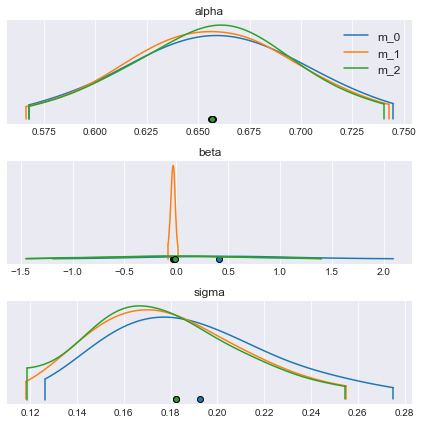

In [25]:
pm.densityplot(traces)

### Compare the three models using WAIC

In [26]:
model_dict = dict(zip([model_0, model_1, model_2], traces))
comp = pm.compare(model_dict, method='BB-pseudo-BMA')
comp

/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
2,-9.13,1.93,0,0.4,3.91,0,1
1,-9.04,2,0.09,0.38,3.98,0.15,1
0,-7.17,1.94,1.95,0.22,3.07,2.88,0


### Weighted averaging of models

In [28]:
ppc_w = pm.sample_ppc_w(traces, 1000, [model_0, model_1, model_2],
                       weights=comp.weight.sort_index(ascending=True),
                       progressbar=False)

In [29]:
ppc_2 = pm.sample_ppc(trace_2, 1000, model_2, progressbar=False)

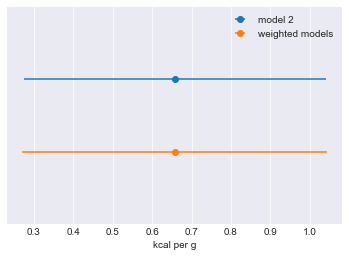

In [30]:
mean_w = ppc_w['kcal'].mean()
hpd_w = pm.hpd(ppc_w['kcal']).mean(0)

mean = ppc_2['kcal'].mean()
hpd = pm.hpd(ppc_2['kcal']).mean(0)

plt.errorbar(mean, 1, xerr=[[mean - hpd]], fmt='o', label='model 2')
plt.errorbar(mean_w, 0, xerr=[[mean_w - hpd_w]], fmt='o', label='weighted models')

plt.yticks([])
plt.ylim(-1, 2)
plt.xlabel('kcal per g')
plt.legend();